In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2"

# 하이퍼파라미터
input_data_column_cnt = 6  # 입력데이터의 컬럼 개수(Variable 개수)
output_data_column_cnt = 1 # 결과데이터의 컬럼 개수
 
seq_length = 14           # 1개 시퀀스의 길이(시계열데이터 입력 개수)
rnn_cell_hidden_dim = 20   # 각 셀의 (hidden)출력 크기
forget_bias = 1.0          # 망각편향(기본값 1.0)
num_stacked_layers = 1     # stacked LSTM layers 개수
keep_prob = 1.0            # dropout할 때 keep할 비율
 
epoch_num = 1000           # 에폭 횟수(학습용전체데이터를 몇 회 반복해서 학습할 것인가 입력)
learning_rate = 0.01       # 학습률

def initialize_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    # config.gpu_options.per_process_gpu_memory_fraction = 0.4
    return tf.Session(config=config)
 
# 랜덤에 의해 똑같은 결과를 재현하도록 시드 설정
# 하이퍼파라미터를 튜닝하기 위한 용도(흔들리면 무엇때문에 좋아졌는지 알기 어려움)
tf.set_random_seed(777)
 
# Standardization
def data_standardization(x):
    x_np = np.asarray(x)
    return (x_np - x_np.mean()) / x_np.std()
 
# 너무 작거나 너무 큰 값이 학습을 방해하는 것을 방지하고자 정규화한다
# x가 양수라는 가정하에 최소값과 최대값을 이용하여 0~1사이의 값으로 변환
# Min-Max scaling
def min_max_scaling(x):
    x_np = np.asarray(x)
    return (x_np - x_np.min()) / (x_np.max() - x_np.min() + 1e-7) # 1e-7은 0으로 나누는 오류 예방차원
 
# 정규화된 값을 원래의 값으로 되돌린다
# 정규화하기 이전의 org_x값과 되돌리고 싶은 x를 입력하면 역정규화된 값을 리턴한다
def reverse_min_max_scaling(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

/etc/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# 데이터를 로딩한다.
kospi_file_name = './dataset/kospi(sds_201501~201805).csv' # 코스피지수
encoding = 'euc-kr' # 문자 인코딩
feature_name = ['Date','Current','High','Low','Volume','Trade','Total']
kospi_raw_dataframe = pd.read_csv(kospi_file_name, names=feature_name, encoding=encoding) #판다스이용 csv파일 로딩
kospi_raw_dataframe.info() # 데이터 정보 출력

del kospi_raw_dataframe['Date'] # Date column 삭제

#CSV file의 Header를 제외한 모든 값에 대해서 float 형태로 변환
kospi_info = kospi_raw_dataframe.values[1:].astype(np.float)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 7 columns):
Date       840 non-null object
Current    840 non-null object
High       840 non-null object
Low        840 non-null object
Volume     840 non-null object
Trade      840 non-null object
Total      840 non-null object
dtypes: object(7)
memory usage: 46.0+ KB


In [3]:
# 데이터를 로딩한다.
stock_file_name = './dataset/sds_201501~201805.csv' # 아마존 주가데이터 파일
encoding = 'euc-kr' # 문자 인코딩
names = ['Date','Open','High','Low','Close','Volume']
raw_dataframe = pd.read_csv(stock_file_name, names=names, encoding=encoding) #판다스이용 csv파일 로딩
raw_dataframe.info() # 데이터 정보 출력
 
# raw_dataframe.drop('Date', axis=1, inplace=True) # 시간열을 제거하고 dataframe 재생성하지 않기
del raw_dataframe['Date'] # 위 줄과 같은 효과
 
stock_info = raw_dataframe.values[1:].astype(np.float) # 금액&거래량 문자열을 부동소수점형으로 변환한다
print("stock_info.shape: ", stock_info.shape)
print("stock_info[0]: ", stock_info[0])
print("stock_info[1]: ", stock_info[1])
print("=======================")
print("kospi_info[0]: ", kospi_info[0])
print("kospi_info[1]: ", kospi_info[1])
print("kospi_info[2]: ", kospi_info[2])
print("kospi_info[3]: ", kospi_info[3])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 6 columns):
Date      840 non-null object
Open      840 non-null object
High      840 non-null object
Low       840 non-null object
Close     840 non-null object
Volume    840 non-null object
dtypes: object(6)
memory usage: 39.5+ KB
stock_info.shape:  (839, 5)
stock_info[0]:  [214000. 217000. 211000. 211000. 166820.]
stock_info[1]:  [219000. 221000. 211500. 214000. 124010.]
kospi_info[0]:  [1.92644000e+03 1.92915000e+03 1.90967000e+03 2.58776000e+05
 3.69602900e+06 1.19801025e+09]
kospi_info[1]:  [1.91575000e+03 1.92196000e+03 1.90337000e+03 3.13443000e+05
 4.70013600e+06 1.19152646e+09]
kospi_info[2]:  [1.88245000e+03 1.90002000e+03 1.87738000e+03 3.03688000e+05
 4.75544000e+06 1.17116716e+09]
kospi_info[3]:  [1.88383000e+03 1.88760000e+03 1.87627000e+03 2.80510000e+05
 3.76267700e+06 1.17199082e+09]


In [4]:
# [:,-1]이 아닌 [:,-1:]이므로 주의하자! 스칼라가아닌 벡터값 산출해야만 쉽게 병합 가능
stock_info[:,-1:]
kospi_info[:,:1]

array([[1926.44],
       [1915.75],
       [1882.45],
       [1883.83],
       [1904.65],
       [1924.7 ],
       [1920.95],
       [1917.14],
       [1913.66],
       [1914.14],
       [1888.13],
       [1902.62],
       [1918.31],
       [1921.23],
       [1920.82],
       [1936.09],
       [1935.68],
       [1952.4 ],
       [1961.58],
       [1951.02],
       [1949.26],
       [1952.68],
       [1951.96],
       [1962.79],
       [1952.84],
       [1955.52],
       [1947.  ],
       [1935.86],
       [1945.7 ],
       [1941.63],
       [1957.5 ],
       [1958.23],
       [1961.45],
       [1968.39],
       [1976.12],
       [1990.47],
       [1993.08],
       [1985.8 ],
       [1996.81],
       [2001.38],
       [1998.29],
       [1998.38],
       [2012.94],
       [1992.82],
       [1984.77],
       [1980.83],
       [1970.59],
       [1985.79],
       [1987.33],
       [2029.91],
       [2028.45],
       [2037.89],
       [2037.24],
       [2036.59],
       [2041.37],
       [20

In [5]:

# 데이터 전처리
# 가격과 거래량 수치의 차이가 많아나서 각각 별도로 정규화한다
 
# 가격형태 데이터들을 정규화한다
# ['Open','High','Low','Close','Adj Close','Volume']에서 'Adj Close'까지 취함
# 곧, 마지막 열 Volume를 제외한 모든 열
price = stock_info[:,:-1]
norm_price = min_max_scaling(price) # 가격형태 데이터 정규화 처리
print("price.shape: ", price.shape)
print("price[0]: ", price[0])
print("norm_price[0]: ", norm_price[0])
print("="*100) # 화면상 구분용
 
# 거래량형태 데이터를 정규화한다
# ['Open','High','Low','Close','Adj Close','Volume']에서 마지막 'Volume'만 취함
# [:,-1]이 아닌 [:,-1:]이므로 주의하자! 스칼라가아닌 벡터값 산출해야만 쉽게 병합 가능
volume = stock_info[:,-1:]
norm_volume = min_max_scaling(volume) # 거래량형태 데이터 정규화 처리
print("volume.shape: ", volume.shape)
print("volume[0]: ", volume[0])
print("norm_volume[0]: ", norm_volume[0])
print("="*100) # 화면상 구분용

#kospi = kospi_info[:,0] #스칼라값
kospi = kospi_info[:,:1] #백터값
norm_kospi = min_max_scaling(kospi)
print("kospi.shape: ", kospi.shape)
print("kospi[0]: ", kospi[0])
print("norm_kospi[0]: ", norm_kospi[0])
print("="*100) # 화면상 구분용


price.shape:  (839, 4)
price[0]:  [214000. 217000. 211000. 211000.]
norm_price[0]:  [0.41609195 0.42988506 0.40229885 0.40229885]
volume.shape:  (839, 1)
volume[0]:  [166820.]
norm_volume[0]:  [0.04349307]
kospi.shape:  (839, 1)
kospi[0]:  [1926.44]
norm_kospi[0]:  [0.12575809]


In [6]:
# 행은 그대로 두고 열을 우측에 붙여 합친다
x = np.concatenate((norm_price, norm_volume, norm_kospi), axis=1) # axis=1, 세로로 합친다
print("x.shape: ", x.shape)
print("x[0]: ", x[0])    # x의 첫 값
print("x[-1]: ", x[-1])  # x의 마지막 값
print("="*100) # 화면상 구분용
 
y = x[:, [-3]] # 타켓은 주식 종가이다
print("y.shape: ", y.shape)
print("y[0]: ",y[0])     # y의 첫 값
print("y[-1]: ",y[-1])   # y의 마지막 값

x.shape:  (839, 6)
x[0]:  [0.41609195 0.42988506 0.40229885 0.40229885 0.04349307 0.12575809]
x[-1]:  [0.80229885 0.89885057 0.78850575 0.89425287 0.21590093 0.77201385]
y.shape:  (839, 1)
y[0]:  [0.40229885]
y[-1]:  [0.89425287]


In [7]:
  
dataX = [] # 입력으로 사용될 Sequence Data
dataY = [] # 출력(타켓)으로 사용
 
for i in range(0, len(y) - seq_length):
    _x = x[i : i+seq_length]
    _y = y[i + seq_length] # 다음 나타날 주가(정답)
    if i is 0:
        print(_x, "->", _y) # 첫번째 행만 출력해 봄
    dataX.append(_x) # dataX 리스트에 추가
    dataY.append(_y) # dataY 리스트에 추가


# 학습용/테스트용 데이터 생성
# 전체 70%를 학습용 데이터로 사용
train_size = int(len(dataY) * 0.7)
# 나머지(30%)를 테스트용 데이터로 사용
test_size = len(dataY) - train_size
 
# 데이터를 잘라 학습용 데이터 생성
trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])
 
# 데이터를 잘라 테스트용 데이터 생성
testX = np.array(dataX[train_size:len(dataX)])
testY = np.array(dataY[train_size:len(dataY)])

[[0.41609195 0.42988506 0.40229885 0.40229885 0.04349307 0.12575809]
 [0.43908046 0.44827586 0.4045977  0.41609195 0.02922534 0.1118457 ]
 [0.44597701 0.45287356 0.43908046 0.44597701 0.00593272 0.06850777]
 [0.46666667 0.46896552 0.44367816 0.44827586 0.01468833 0.07030376]
 [0.46896552 0.47126437 0.45287356 0.46666667 0.01520991 0.09739972]
 [0.44137931 0.45517241 0.42758621 0.45287356 0.01375448 0.12349358]
 [0.44367816 0.45517241 0.43678161 0.43908046 0.01832541 0.11861319]
 [0.45977011 0.46206897 0.44137931 0.45977011 0.00770944 0.1136547 ]
 [0.44827586 0.45517241 0.44137931 0.44827586 0.01108857 0.10912569]
 [0.45057471 0.46436782 0.44597701 0.45287356 0.01032169 0.10975038]
 [0.45517241 0.45747126 0.43678161 0.45287356 0.00485323 0.07589995]
 [0.44597701 0.45977011 0.43678161 0.44137931 0.01410809 0.0947578 ]
 [0.45977011 0.47816092 0.44597701 0.45057471 0.00866062 0.11517739]
 [0.44137931 0.46206897 0.43908046 0.45977011 0.00918554 0.11897759]] -> [0.45287356]


In [8]:
# 텐서플로우 플레이스홀더 생성
# 입력 X, 출력 Y를 생성한다
X = tf.placeholder(tf.float32, [None, seq_length, input_data_column_cnt])
print("X: ", X)
Y = tf.placeholder(tf.float32, [None, 1])
print("Y: ", Y)
 
# 검증용 측정지표를 산출하기 위한 targets, predictions를 생성한다
targets = tf.placeholder(tf.float32, [None, 1])
print("targets: ", targets)
 
predictions = tf.placeholder(tf.float32, [None, 1])
print("predictions: ", predictions)
 
# 모델(LSTM 네트워크) 생성
def lstm_cell():
    # LSTM셀을 생성
    # num_units: 각 Cell 출력 크기
    # forget_bias:  to the biases of the forget gate 
    #              (default: 1)  in order to reduce the scale of forgetting in the beginning of the training.
    # state_is_tuple: True ==> accepted and returned states are 2-tuples of the c_state and m_state.
    # state_is_tuple: False ==> they are concatenated along the column axis.
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=rnn_cell_hidden_dim, 
                                        forget_bias=forget_bias, state_is_tuple=True, activation=tf.nn.softsign)
    if keep_prob < 1.0:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell
 
# num_stacked_layers개의 층으로 쌓인 Stacked RNNs 생성
stackedRNNs = [lstm_cell() for _ in range(num_stacked_layers)]
multi_cells = tf.contrib.rnn.MultiRNNCell(stackedRNNs, state_is_tuple=True) if num_stacked_layers > 1 else lstm_cell()
 
# RNN Cell(여기서는 LSTM셀임)들을 연결
hypothesis, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)
print("hypothesis: ", hypothesis)
 
# [:, -1]를 잘 살펴보자. LSTM RNN의 마지막 (hidden)출력만을 사용했다.
# 과거 여러 거래일의 주가를 이용해서 다음날의 주가 1개를 예측하기때문에 MANY-TO-ONE형태이다
hypothesis = tf.contrib.layers.fully_connected(hypothesis[:, -1], output_data_column_cnt, activation_fn=tf.identity)
 
# 손실함수로 평균제곱오차를 사용한다
loss = tf.reduce_sum(tf.square(hypothesis - Y))
# 최적화함수로 AdamOptimizer를 사용한다
optimizer = tf.train.AdamOptimizer(learning_rate)
# optimizer = tf.train.RMSPropOptimizer(learning_rate) # LSTM과 궁합 별로임
 
train = optimizer.minimize(loss)
 
# RMSE(Root Mean Square Error)
# 제곱오차의 평균을 구하고 다시 제곱근을 구하면 평균 오차가 나온다
# rmse = tf.sqrt(tf.reduce_mean(tf.square(targets-predictions))) # 아래 코드와 같다
rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(targets, predictions)))

train_error_summary = [] # 학습용 데이터의 오류를 중간 중간 기록한다
test_error_summary = []  # 테스트용 데이터의 오류를 중간 중간 기록한다
test_predict = ''        # 테스트용데이터로 예측한 결과
 
sess = tf.Session()
sess.run(tf.global_variables_initializer())

 

X:  Tensor("Placeholder:0", shape=(?, 14, 6), dtype=float32)
Y:  Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)
targets:  Tensor("Placeholder_2:0", shape=(?, 1), dtype=float32)
predictions:  Tensor("Placeholder_3:0", shape=(?, 1), dtype=float32)
hypothesis:  Tensor("rnn/transpose_1:0", shape=(?, 14, 20), dtype=float32)


In [9]:
 
# 학습한다
start_time = datetime.datetime.now() # 시작시간을 기록한다
print('학습을 시작합니다...')
for epoch in range(epoch_num):
    _, _loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
    if ((epoch+1) % 100 == 0) or (epoch == epoch_num-1): # 100번째마다 또는 마지막 epoch인 경우
        # 학습용데이터로 rmse오차를 구한다
        train_predict = sess.run(hypothesis, feed_dict={X: trainX})
        train_error = sess.run(rmse, feed_dict={targets: trainY, predictions: train_predict})
        train_error_summary.append(train_error)
 
        # 테스트용데이터로 rmse오차를 구한다
        test_predict = sess.run(hypothesis, feed_dict={X: testX})
        test_error = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
        test_error_summary.append(test_error)
        
        # 현재 오류를 출력한다
        print("epoch: {}, train_error(A): {}, test_error(B): {}, B-A: {}".format(epoch+1, train_error, test_error, test_error-train_error))
        
end_time = datetime.datetime.now() # 종료시간을 기록한다
elapsed_time = end_time - start_time # 경과시간을 구한다
print('elapsed_time:',elapsed_time)
print('elapsed_time per epoch:',elapsed_time/epoch_num)
 

학습을 시작합니다...
epoch: 100, train_error(A): 0.02077450416982174, test_error(B): 0.040566589683294296, B-A: 0.019792085513472557
epoch: 200, train_error(A): 0.016911523416638374, test_error(B): 0.03483763709664345, B-A: 0.017926113680005074
epoch: 300, train_error(A): 0.014808201231062412, test_error(B): 0.02928982861340046, B-A: 0.014481627382338047
epoch: 400, train_error(A): 0.013091097585856915, test_error(B): 0.025142209604382515, B-A: 0.0120511120185256
epoch: 500, train_error(A): 0.01177070289850235, test_error(B): 0.02323252707719803, B-A: 0.011461824178695679
epoch: 600, train_error(A): 0.010747244581580162, test_error(B): 0.02264740876853466, B-A: 0.011900164186954498
epoch: 700, train_error(A): 0.00983794592320919, test_error(B): 0.022277282550930977, B-A: 0.012439336627721786
epoch: 800, train_error(A): 0.009051336906850338, test_error(B): 0.02245011366903782, B-A: 0.013398776762187481
epoch: 900, train_error(A): 0.00853761751204729, test_error(B): 0.022504253312945366, B-A: 0.

In [10]:

# 하이퍼파라미터 출력
print('input_data_column_cnt:', input_data_column_cnt, end='')
print(',output_data_column_cnt:', output_data_column_cnt, end='')
 
print(',seq_length:', seq_length, end='')
print(',rnn_cell_hidden_dim:', rnn_cell_hidden_dim, end='')
print(',forget_bias:', forget_bias, end='')
print(',num_stacked_layers:', num_stacked_layers, end='')
print(',keep_prob:', keep_prob, end='')
 
print(',epoch_num:', epoch_num, end='')
print(',learning_rate:', learning_rate, end='')
 
print(',train_error:', train_error_summary[-1], end='')
print(',test_error:', test_error_summary[-1], end='')
print(',min_test_error:', np.min(test_error_summary))
 

input_data_column_cnt: 6,output_data_column_cnt: 1,seq_length: 14,rnn_cell_hidden_dim: 20,forget_bias: 1.0,num_stacked_layers: 1,keep_prob: 1.0,epoch_num: 1000,learning_rate: 0.01,train_error: 0.008298069,test_error: 0.02226405,min_test_error: 0.02226405


Text(0,0.5,'Root Mean Square Error')

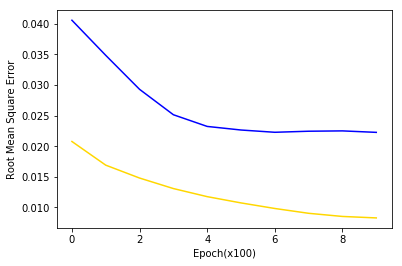

In [11]:
# 결과 그래프 출력

plt.figure(1)
plt.plot(train_error_summary, 'gold')
plt.plot(test_error_summary, 'b')
plt.xlabel('Epoch(x100)')
plt.ylabel('Root Mean Square Error')

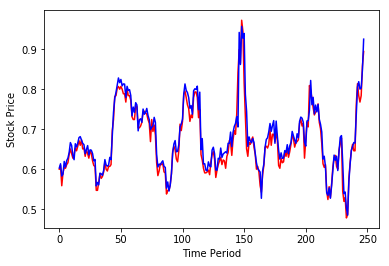

In [12]:
test_predict = sess.run(hypothesis, feed_dict={X: testX})
test_error = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
test_error_summary.append(test_error)

plt.figure(3)
plt.plot(testY, 'r', label="Real")
plt.plot(test_predict, 'b', label="Predict")
plt.xlabel('Time Period')
plt.ylabel('Stock Price')
plt.show()

In [12]:

# sequence length만큼의 가장 최근 데이터를 슬라이싱한다
recent_data = np.array([x[len(x)-seq_length : ]])
print("recent_data.shape:", recent_data.shape)
print("recent_data:", recent_data)
 
# 내일 종가를 예측해본다
test_predict = sess.run(hypothesis, feed_dict={X: recent_data})
 
print("test_predict", test_predict[0])
test_predict = reverse_min_max_scaling(price,test_predict) # 금액데이터 역정규화한다
print("Tomorrow's stock price", test_predict[0]) # 예측한 주가를 출력한다

recent_data.shape: (1, 14, 5)
recent_data: [[[0.57701149 0.57701149 0.47586207 0.48735632 0.26119605]
  [0.6183908  0.62988506 0.57241379 0.57701149 0.10630273]
  [0.64827586 0.66666667 0.6045977  0.61609195 0.04897253]
  [0.65057471 0.65747126 0.63908046 0.64597701 0.02059439]
  [0.65287356 0.67126437 0.64827586 0.66206897 0.03652885]
  [0.65747126 0.67816092 0.63908046 0.64597701 0.07677843]
  [0.74712644 0.74942529 0.62988506 0.64597701 0.31303646]
  [0.79310345 0.8091954  0.76091954 0.76091954 0.0813967 ]
  [0.8091954  0.82298851 0.7954023  0.8137931  0.06405146]
  [0.7816092  0.8137931  0.77471264 0.78390805 0.04997237]
  [0.77701149 0.80229885 0.76781609 0.76781609 0.04666923]
  [0.83678161 0.84597701 0.77701149 0.78390805 0.12276277]
  [0.91494253 0.93793103 0.84827586 0.85747126 0.17242419]
  [0.80229885 0.89885057 0.78850575 0.89425287 0.21590093]]]
test_predict [0.78394794]
Tomorrow's stock price [294008.7]


In [18]:
raw_dataframe.head()

,Open,High,Low,Close,Adj Close,Volume
0,Open,High,Low,Close,Adj Close,Volume
1,273.980011,277.980011,273.500000,277.570007,277.570007,3029500
2,279.179993,280.200012,274.540009,277.549988,277.549988,2519500
3,276.190002,279.829987,276.190002,277.690002,277.690002,3193300
4,279.000000,283.290009,277.160004,282.100006,282.100006,2888200


In [19]:
stock_file_name = './dataset/AMZN.csv' # 아마존 주가데이터 파일
encoding = 'euc-kr' # 문자 인코딩
names = ['Date','Open','High','Low','Close','Adj Close','Volume']
raw_dataframe = pd.read_csv(stock_file_name, names=names, encoding=encoding)

In [21]:
raw_dataframe.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1256,2018-06-20,1742.500000,1762.930054,1741.359985,1750.079956,1750.079956,4332600
1257,2018-06-21,1760.000000,1763.099976,1717.560059,1730.219971,1730.219971,4941100
1258,2018-06-22,1742.619995,1743.000000,1711.900024,1715.670044,1715.670044,4075100
1259,2018-06-25,1702.510010,1705.000000,1646.310059,1663.150024,1663.150024,7511200
1260,2018-06-26,1672.369995,1701.569946,1663.339966,1691.089966,1691.089966,4378700
